In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter

# Acc and ECE

In [5]:
datasets = ["bloodmnist", "dermamnist", "pneumoniamnist", "organsmnist"]

columns = [
    "dataset",
    "seed",
    "experiment_type",
    "num_labeled",
    "test_acc",
    "test_loss",
    "test_ece",
    "acc_per_class",
    "class_dist",
    "full_dist",
    "optim",
]
df = pd.DataFrame(columns=columns)


for dataset in datasets:
    test_dirs = [f"./runs/{dataset}/test", f"./test/{dataset}"]

    for test_dir in test_dirs:
        if not os.path.exists(test_dir):
            continue

        for seed in os.listdir(test_dir):
            for folder in os.listdir(f"{test_dir}/{seed}"):
                exp_type, calibrated, optim, num_labeled = folder.split("_")
                exp_type = f"{exp_type}_{calibrated}"

                test_metrics = pd.read_csv(f"{test_dir}/{seed}/{folder}/test_metrics.csv")
                acc_per_class = pd.read_csv(f"{test_dir}/{seed}/{folder}/accuracy_per_class.csv")
                class_dist = pd.read_csv(f"{test_dir}/{seed}/{folder}/class_distribution.csv")
                full_dist = pd.read_csv(f"{test_dir}/{seed}/{folder}/full_distribution.csv")

                acc_per_class_dict = {}
                class_dist_dict = {}
                full_dist_dict = {}

                for acc_col, dist_col, full_col in zip(acc_per_class.columns, class_dist.columns, full_dist.columns):
                    acc_per_class_dict[acc_col] = acc_per_class[acc_col].values[0]
                    class_dist_dict[dist_col] = class_dist[dist_col].values[0]
                    full_dist_dict[full_col] = full_dist[full_col].values[0]

                test_acc = test_metrics["test_acc"].values[-1]
                test_loss = test_metrics["test_loss"].values[-1]
                test_ece = test_metrics["test_ece"].values[-1]

                df.loc[len(df)] = {
                    "dataset": dataset,
                    "seed": int(seed.split("_")[-1]),
                    "experiment_type": exp_type,
                    "num_labeled": int(num_labeled),
                    "test_acc": test_acc,
                    "test_loss": test_loss,
                    "test_ece": test_ece,
                    "acc_per_class": acc_per_class_dict,
                    "class_dist": class_dist_dict,
                    "full_dist": full_dist_dict,
                    "optim": optim,
                }

df = df.sort_values(by=["experiment_type", "num_labeled"])

In [6]:
df_agg = df.groupby(["dataset", "experiment_type", "num_labeled", "optim"]).agg(
    {
        "test_acc": ["mean", "std"],
        "test_loss": ["mean", "std"],
        "test_ece": ["mean", "std"],
    }
)

df_agg

test_acc            \
                                                       mean       std   
dataset        experiment_type  num_labeled optim                       
bloodmnist     active_jempp     250         sgd    0.825490  0.000000   
                                500         sgd    0.892137  0.000000   
                                750         sgd    0.923999  0.000000   
                                1000        sgd    0.924554  0.000092   
                                1250        sgd    0.937153  0.000000   
...                                                     ...       ...   
pneumoniamnist active_softmax   3750        sgd    0.911859  0.000000   
                                4000        adam   0.876603  0.000000   
                                            sgd    0.908654  0.000000   
               baseline_softmax 4000        adam   0.876603  0.000000   
                                            sgd    0.907051  0.000000   

                                                  test_loss                \
                                                       mean           std   
dataset        experiment_type  num_labeled optim                           
bloodmnist     active_jempp     250         sgd    0.898177  1.716375e-05   
                                500         sgd    0.365079  6.917957e-06   
                                750         sgd    0.288293  3.401429e-06   
                                1000        sgd    0.276160  7.679395e-06   
                                1250        sgd    0.204140  4.048794e-07   
...                                                     ...           ...   
pneumoniamnist active_softmax   3750        sgd    0.322716  0.000000e+00   
                                4000        adam   0.572496  0.000000e+00   
                                            sgd    0.341683  0.000000e+00   
               baseline_softmax 4000        adam   0.538095  0.000000e+00   
                                            sgd    0.340154  0.000000e+00   

                                                   test_ece                
                                                       mean           std  
dataset        experiment_type  num_labeled optim                          
bloodmnist     active_jempp     250         sgd    0.120293  1.393045e-06  
                                500         sgd    0.050734  2.024287e-07  
                                750         sgd    0.042941  7.750175e-07  
                                1000        sgd    0.040557  9.292817e-05  
                                1250        sgd    0.024737  1.714174e-07  
...                                                     ...           ...  
pneumoniamnist active_softmax   3750        sgd    0.083110  0.000000e+00  
                                4000        adam   0.123319  0.000000e+00  
                                            sgd    0.075840  0.000000e+00  
               baseline_softmax 4000        adam   0.123313  0.000000e+00  
                                            sgd    0.078388  0.000000e+00  

[165 rows x 6 columns]

In [13]:
results = df_agg.xs("pneumoniamnist", level="dataset")
# get test ece of actvive_softmax
active_softmax = results.xs("active_softmax", level="experiment_type")
active_softmax["test_ece"]

mean  std
num_labeled optim               
250         adam   0.172337  0.0
            sgd    0.096542  0.0
500         adam   0.158731  0.0
            sgd    0.147479  0.0
750         adam   0.145763  0.0
            sgd    0.107459  0.0
1000        adam   0.142729  0.0
            sgd    0.149448  0.0
1250        adam   0.141893  0.0
            sgd    0.109346  0.0
1500        adam   0.119684  0.0
            sgd    0.101750  0.0
1750        adam   0.097282  0.0
            sgd    0.159831  0.0
2000        adam   0.114157  0.0
            sgd    0.068710  0.0
2250        adam   0.117430  0.0
            sgd    0.092945  0.0
2500        adam   0.115514  0.0
            sgd    0.044046  0.0
2750        adam   0.129867  0.0
            sgd    0.070424  0.0
3000        adam   0.126670  0.0
            sgd    0.116308  0.0
3250        adam   0.117720  0.0
            sgd    0.094404  0.0
3500        adam   0.115371  0.0
            sgd    0.167814  0.0
3750        adam   0.119889  0.0
            sgd    0.083110  0.0
4000        adam   0.123319  0.0
            sgd    0.075840  0.0

In [8]:
# Reset the index of the results DataFrame
# Get the index of the minimum test_ece for each experiment type
min_ece_idx = results.groupby(["experiment_type", "optim"])["test_ece"].idxmin()
min_ece_idx

test_ece  \
                                                  mean   
experiment_type  optim                                   
active_jempp     adam       (active_jempp, 1000, adam)   
                 sgd         (active_jempp, 1000, sgd)   
active_softmax   adam     (active_softmax, 1750, adam)   
                 sgd       (active_softmax, 2500, sgd)   
baseline_softmax adam   (baseline_softmax, 4000, adam)   
                 sgd     (baseline_softmax, 4000, sgd)   

                                                        
                                                   std  
experiment_type  optim                                  
active_jempp     adam        (active_jempp, 250, adam)  
                 sgd         (active_jempp, 3000, sgd)  
active_softmax   adam      (active_softmax, 250, adam)  
                 sgd        (active_softmax, 250, sgd)  
baseline_softmax adam   (baseline_softmax, 4000, adam)  
                 sgd     (baseline_softmax, 4000, sgd)

bloodmnist sgd


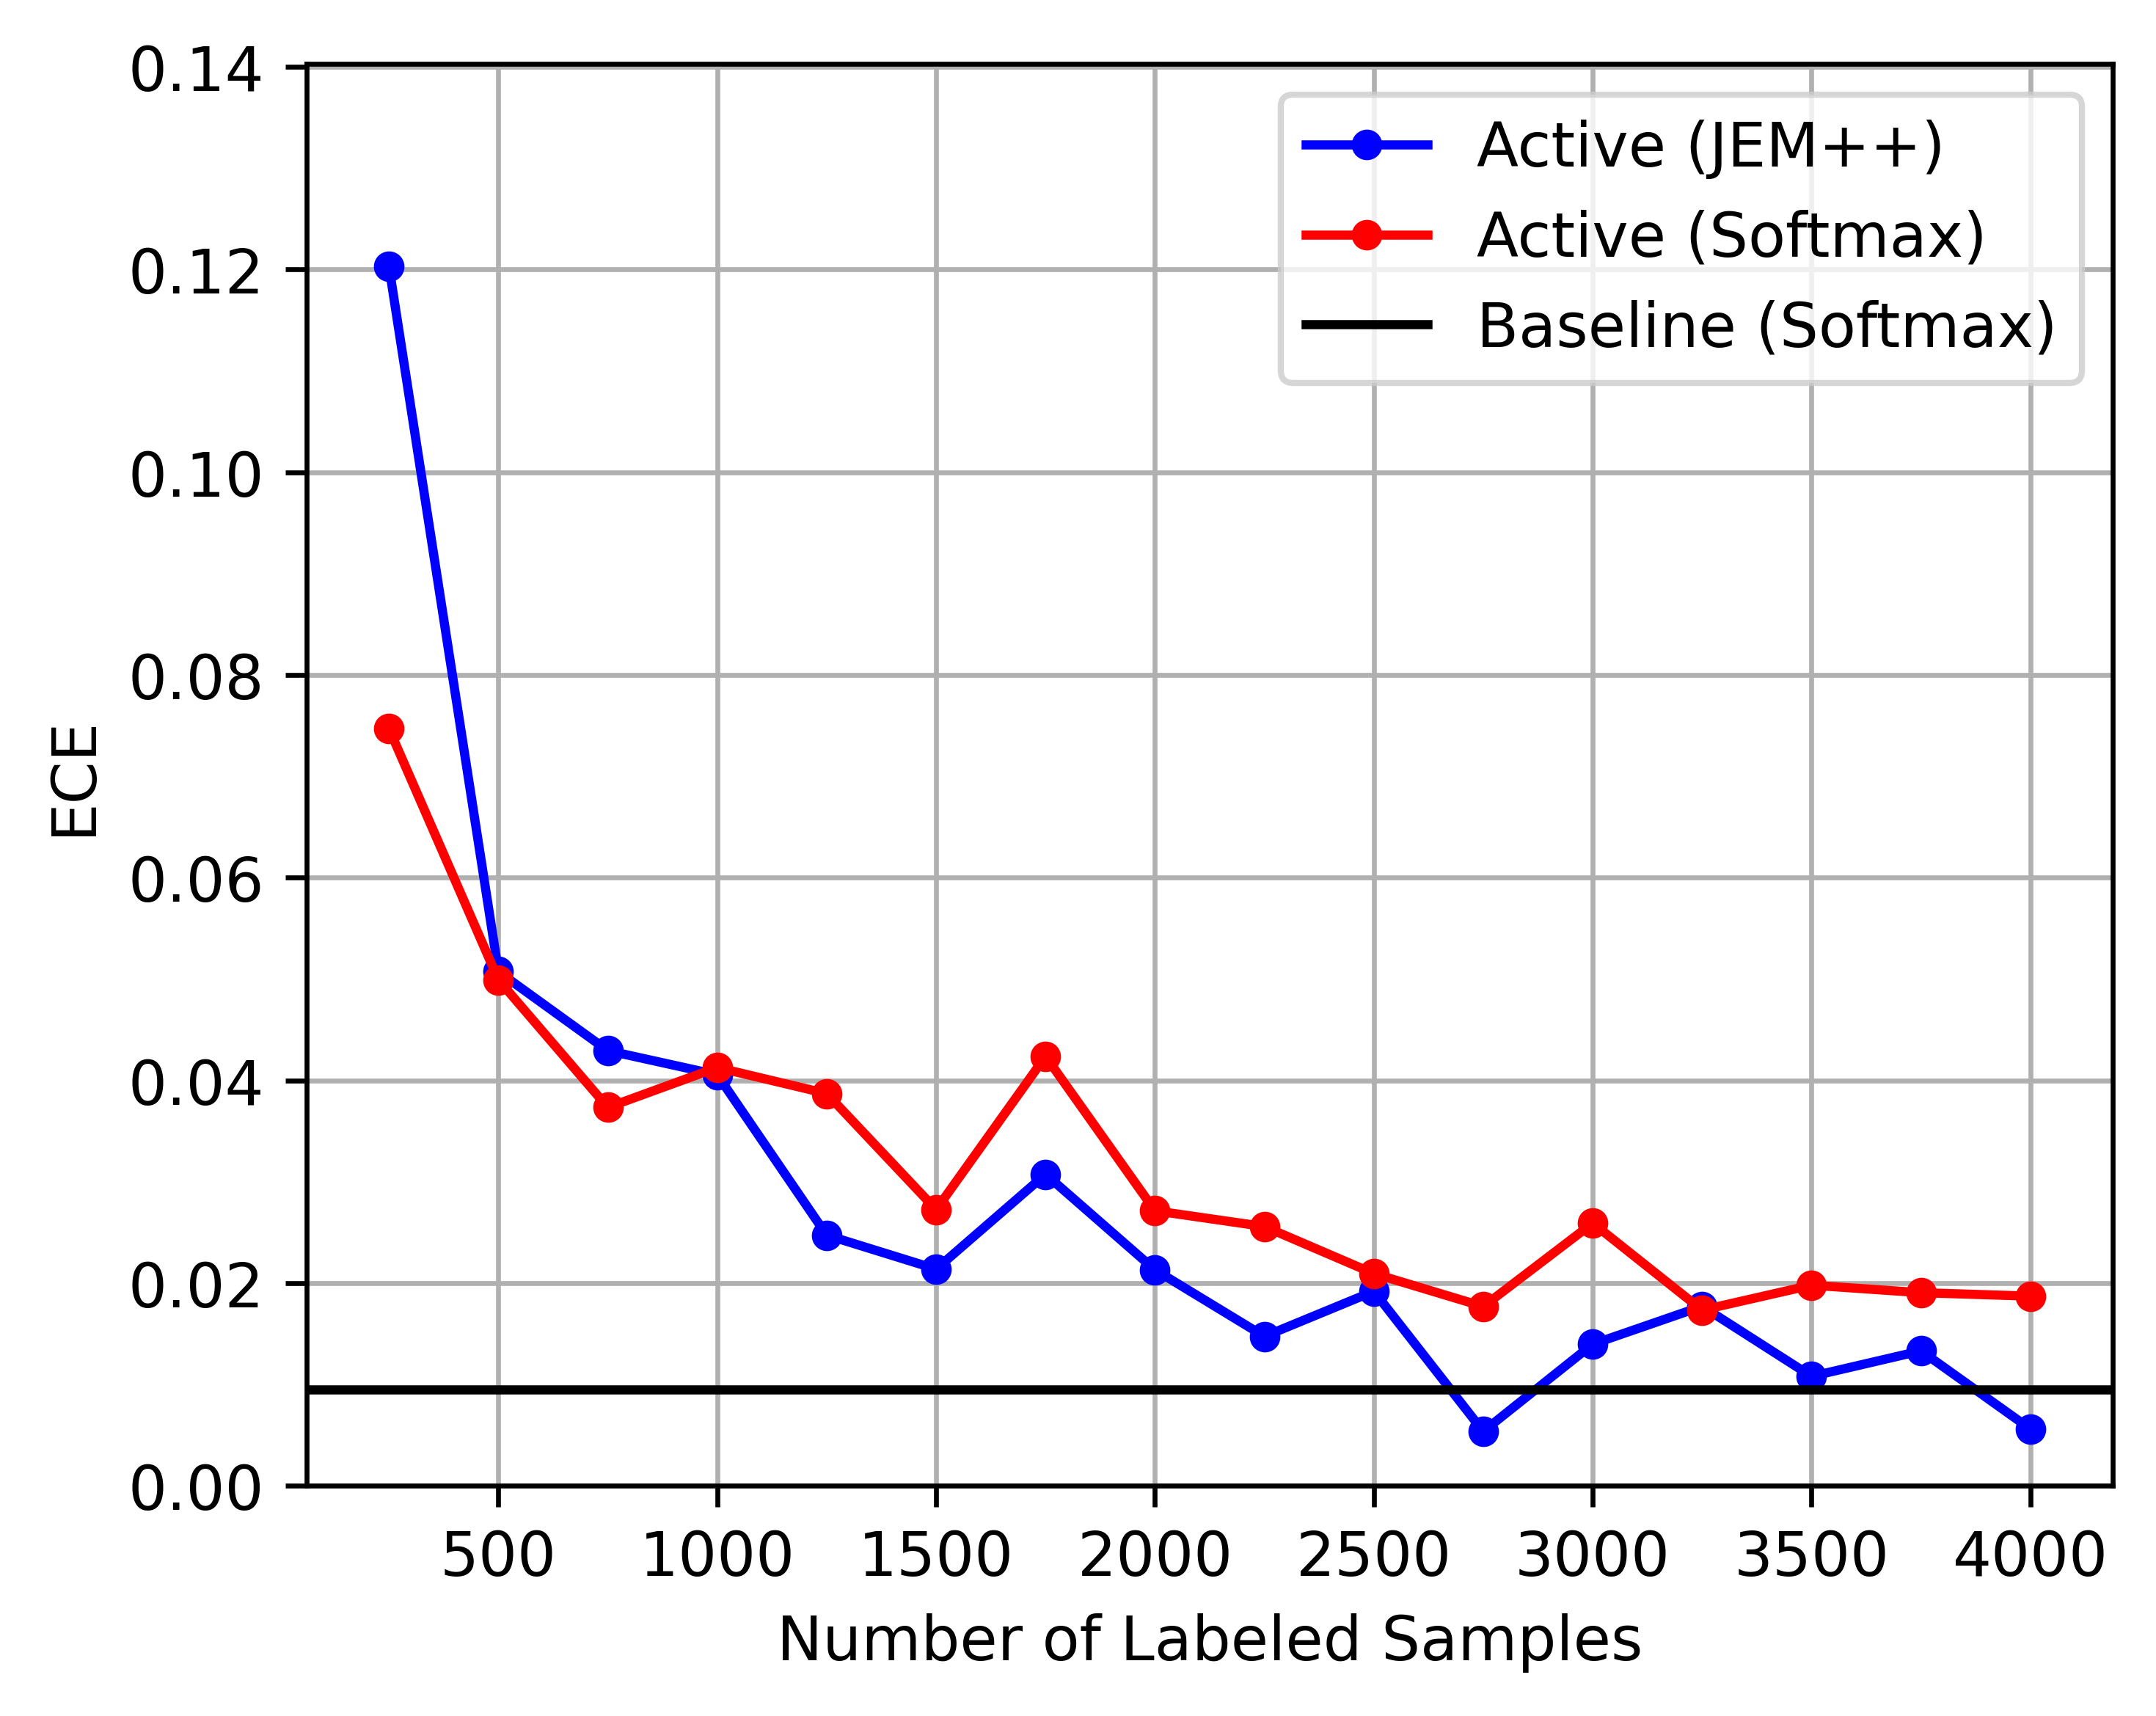

dermamnist sgd


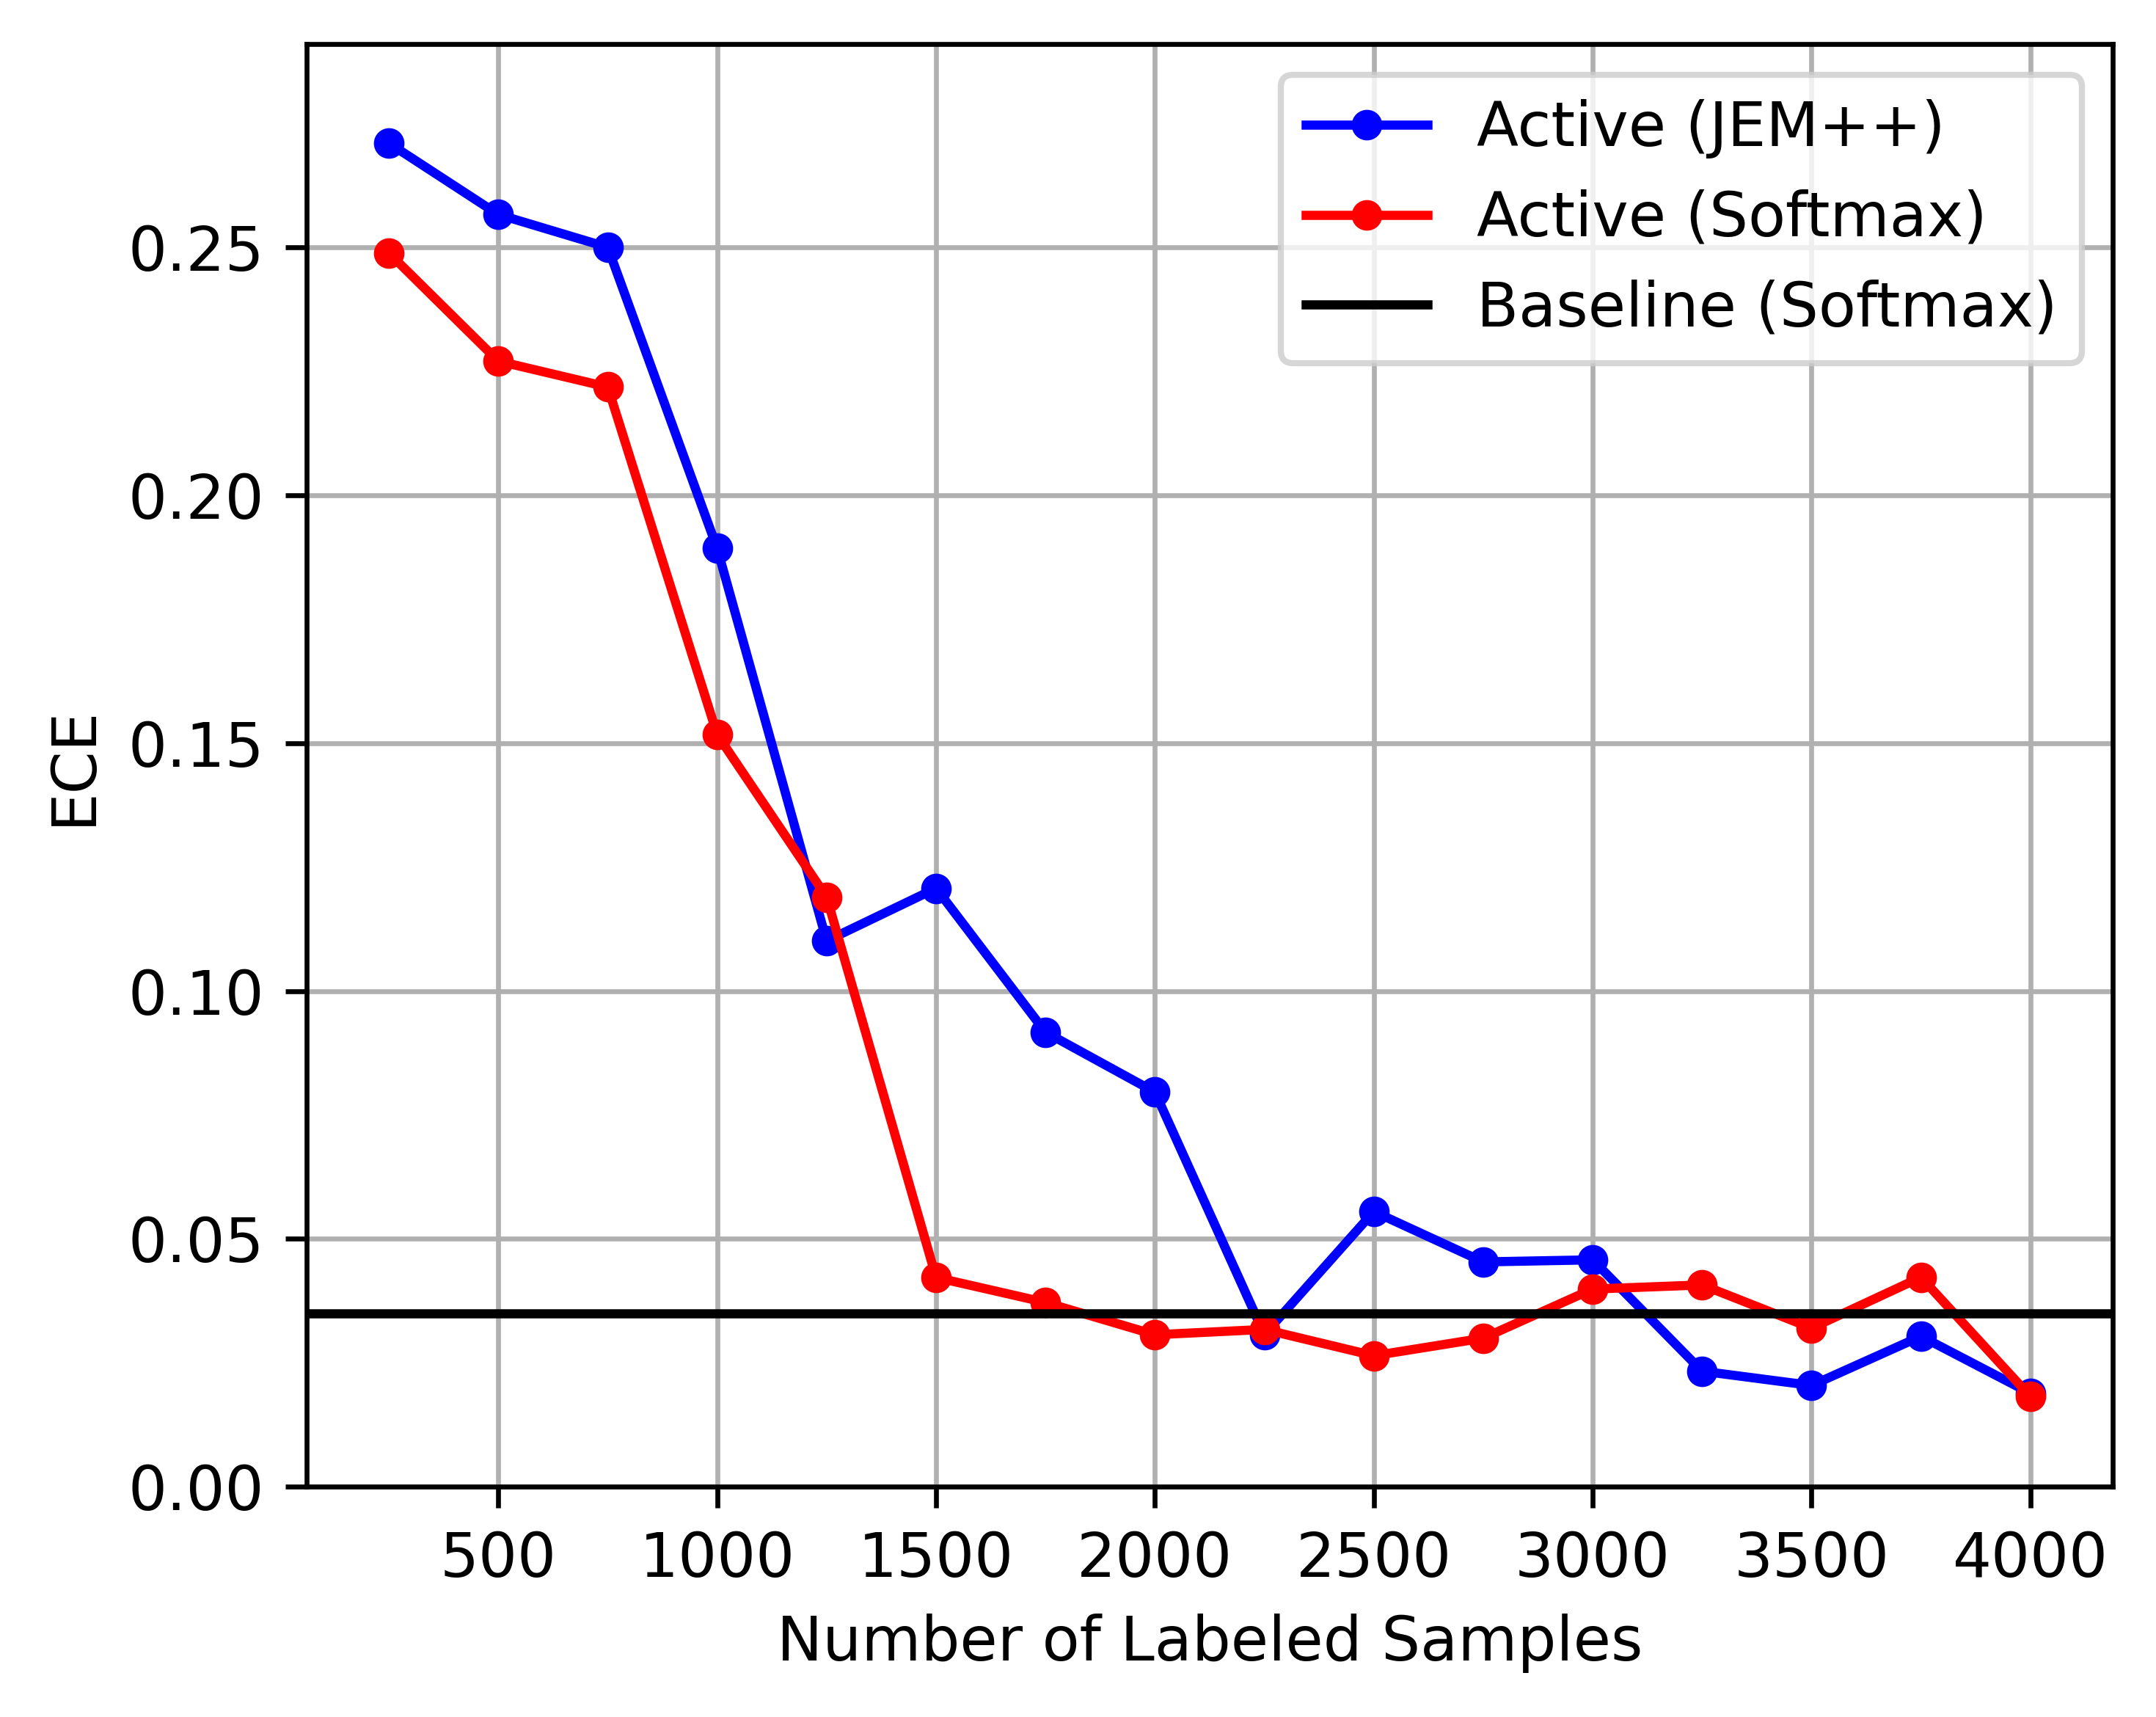

organsmnist sgd


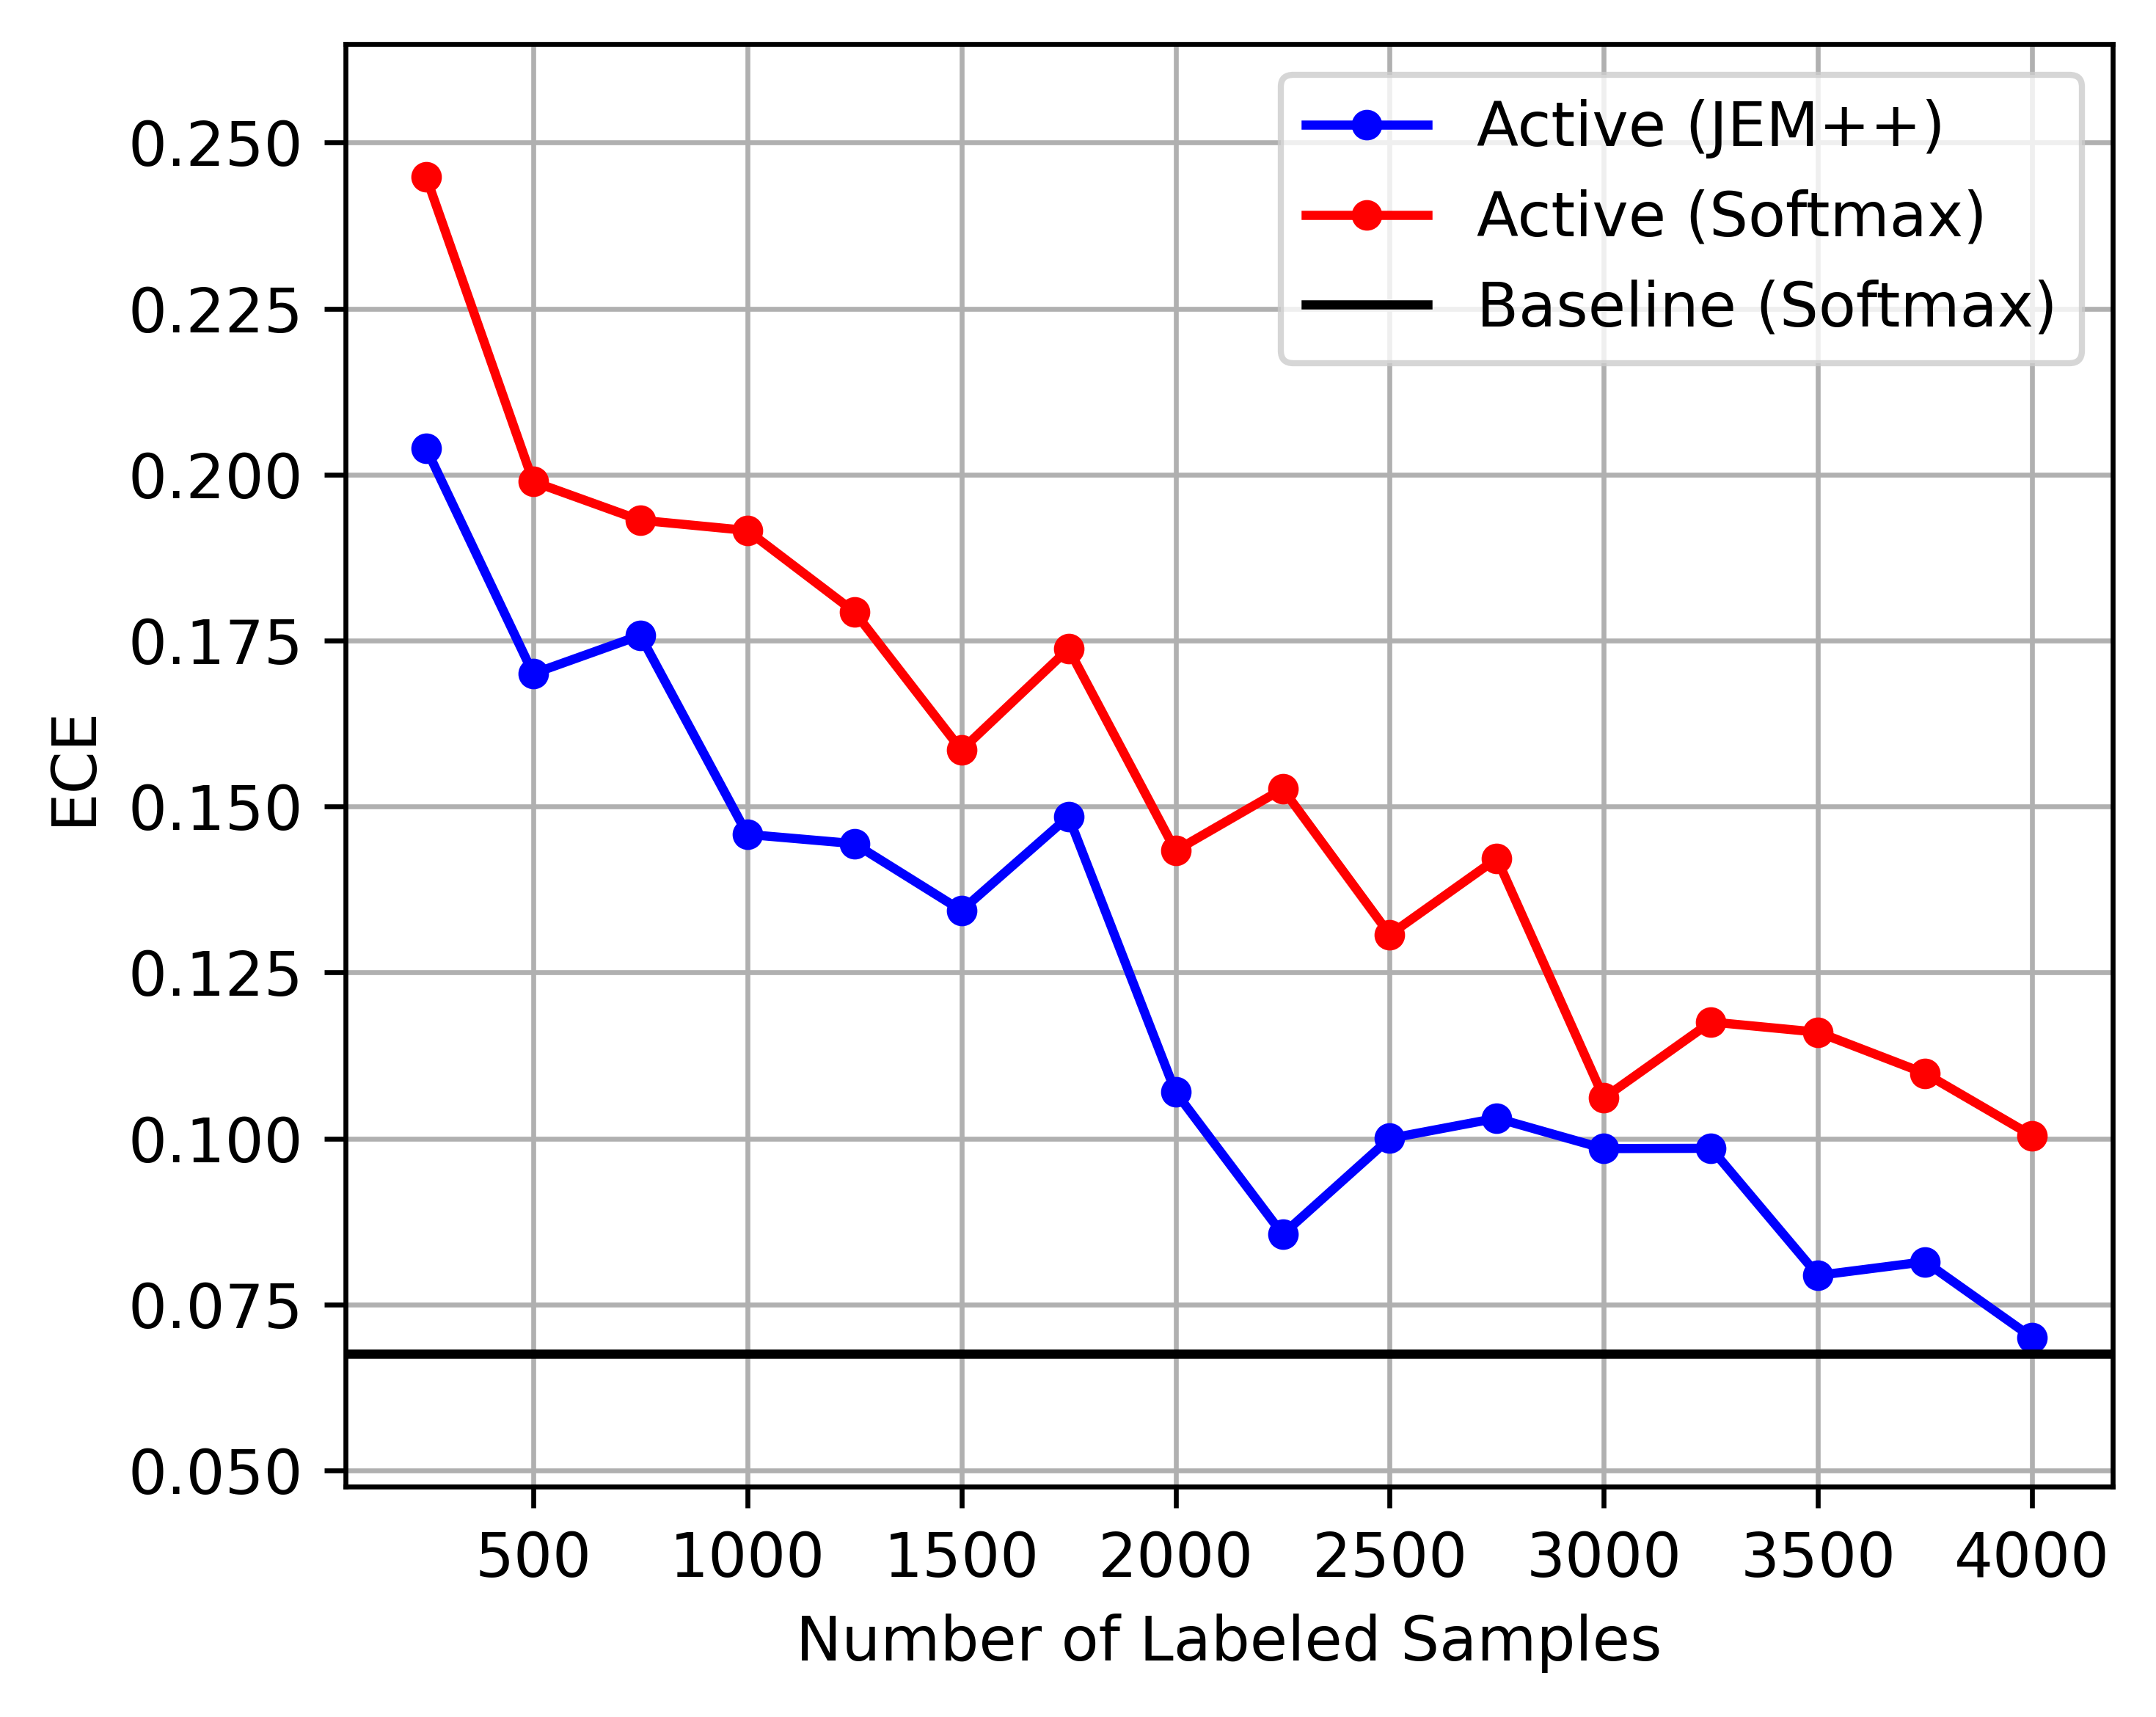

pneumoniamnist sgd


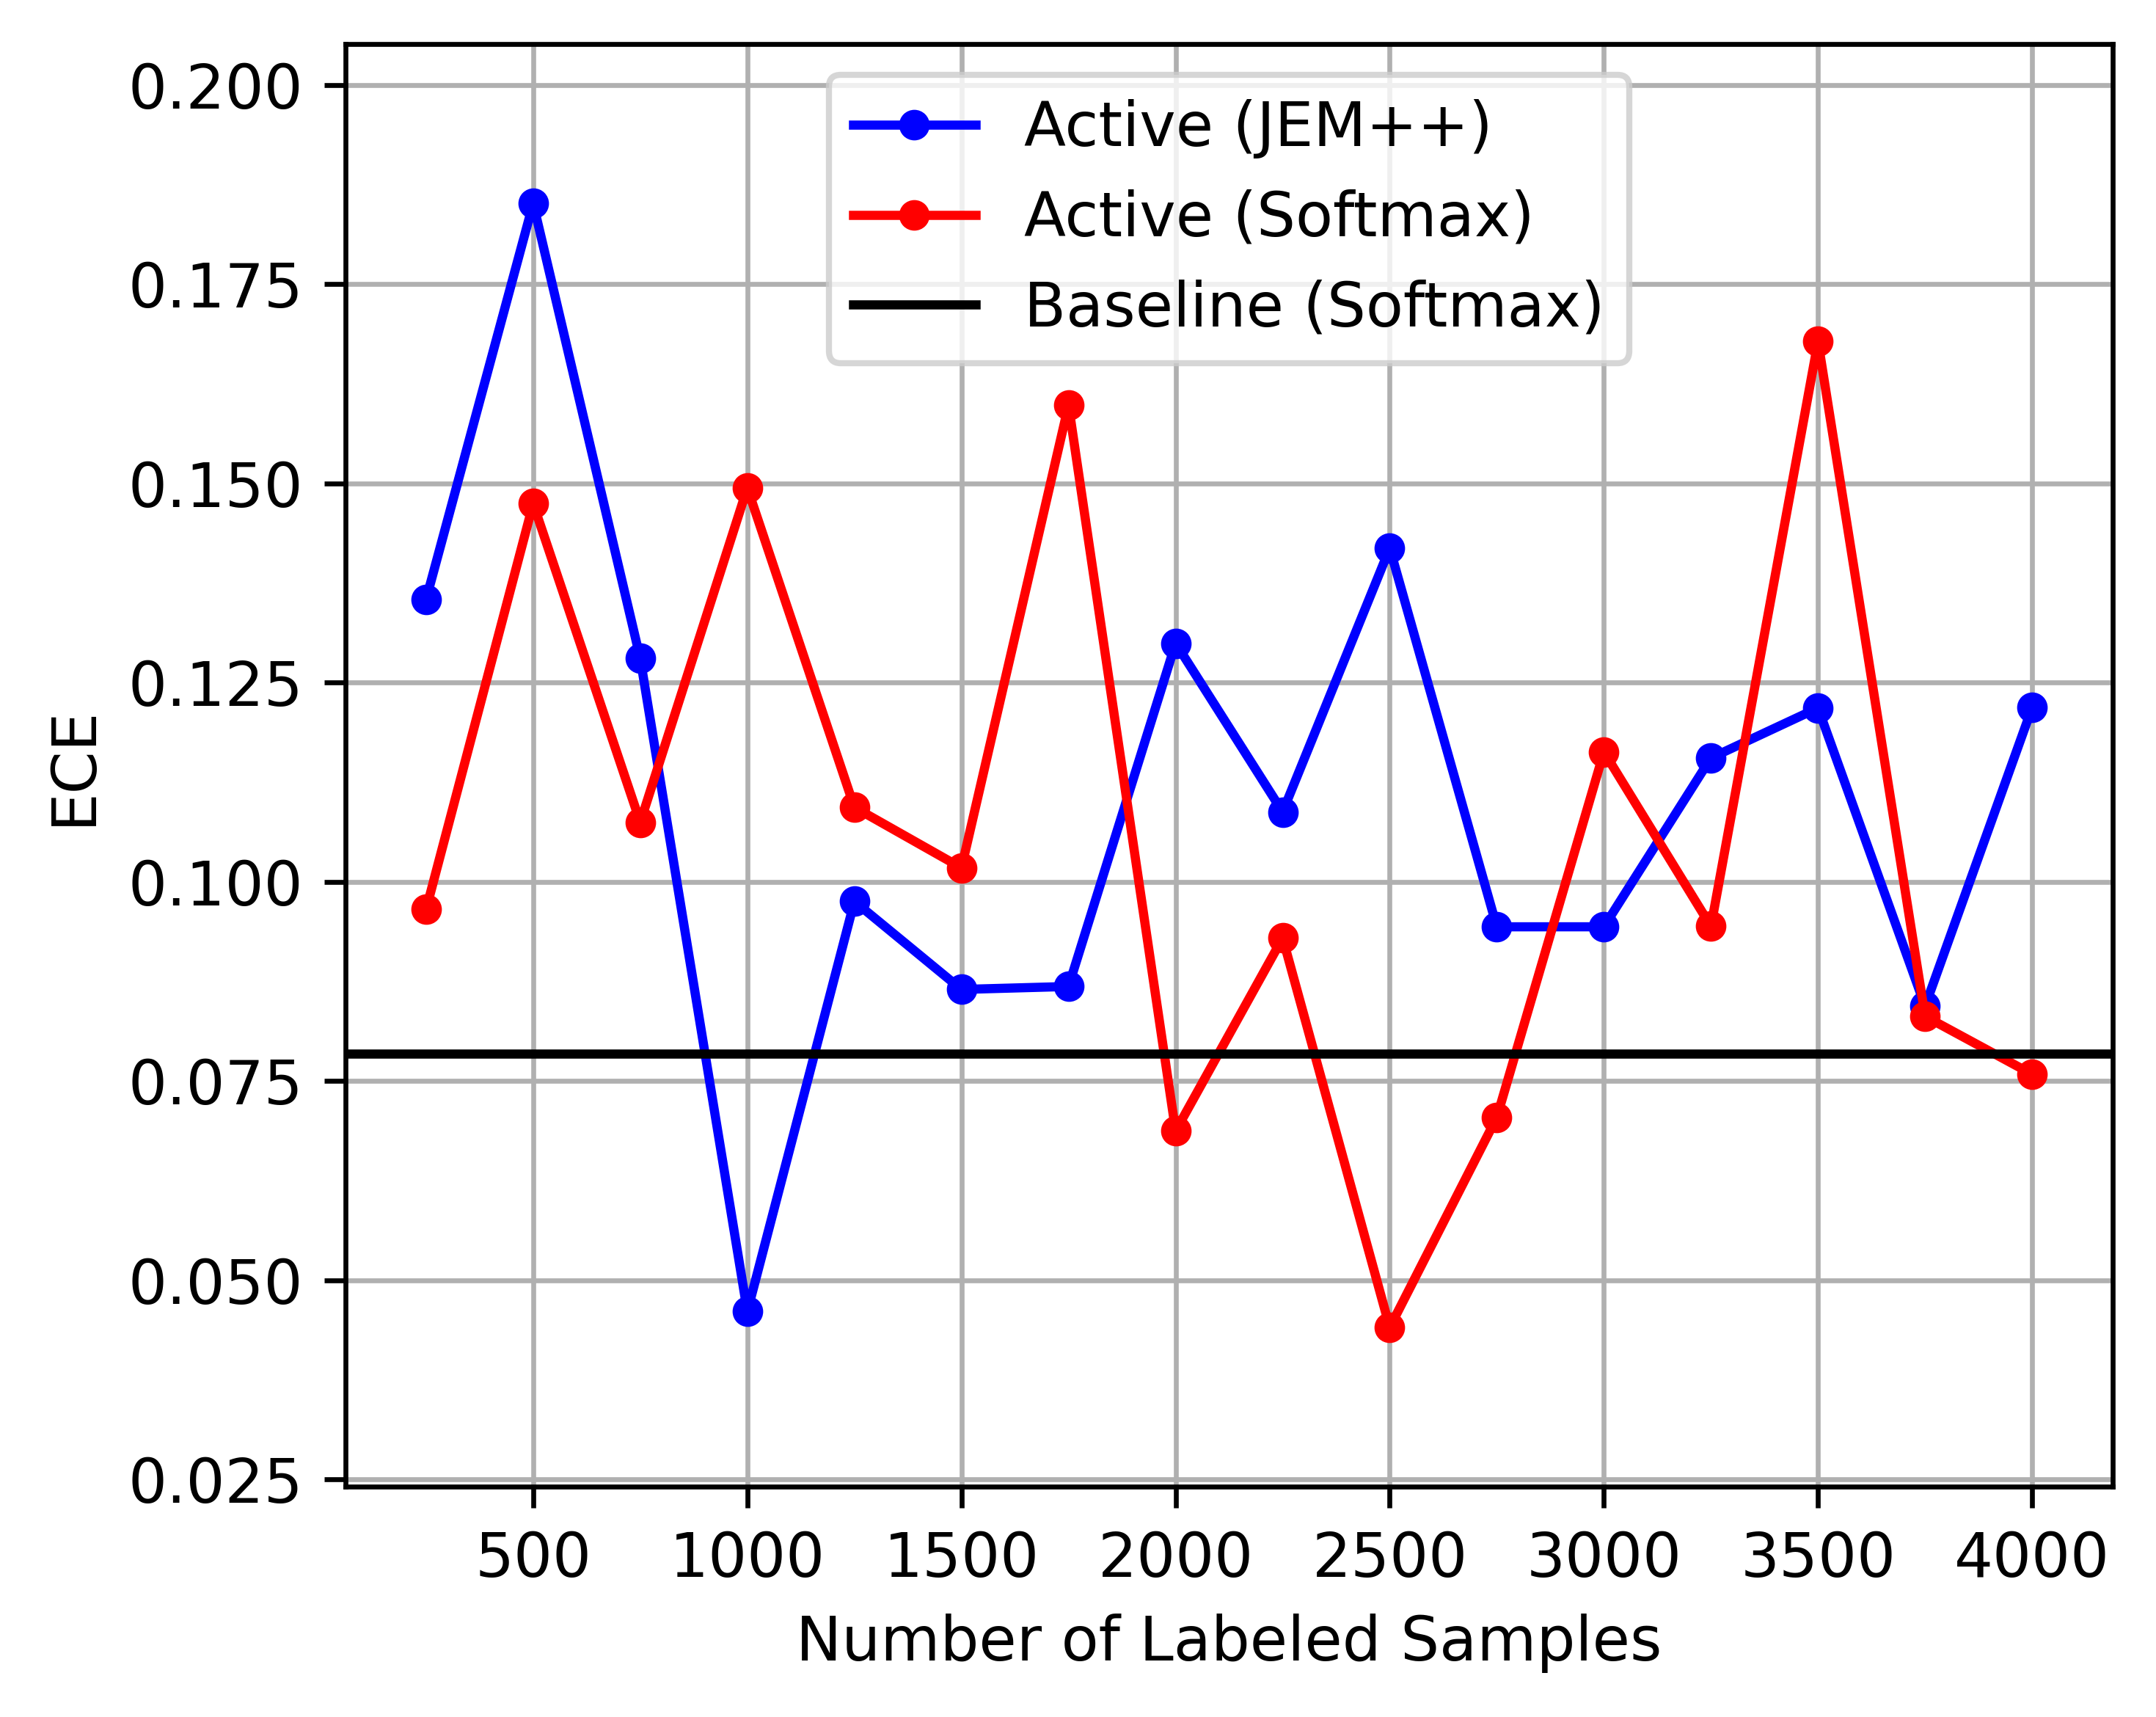

pneumoniamnist adam


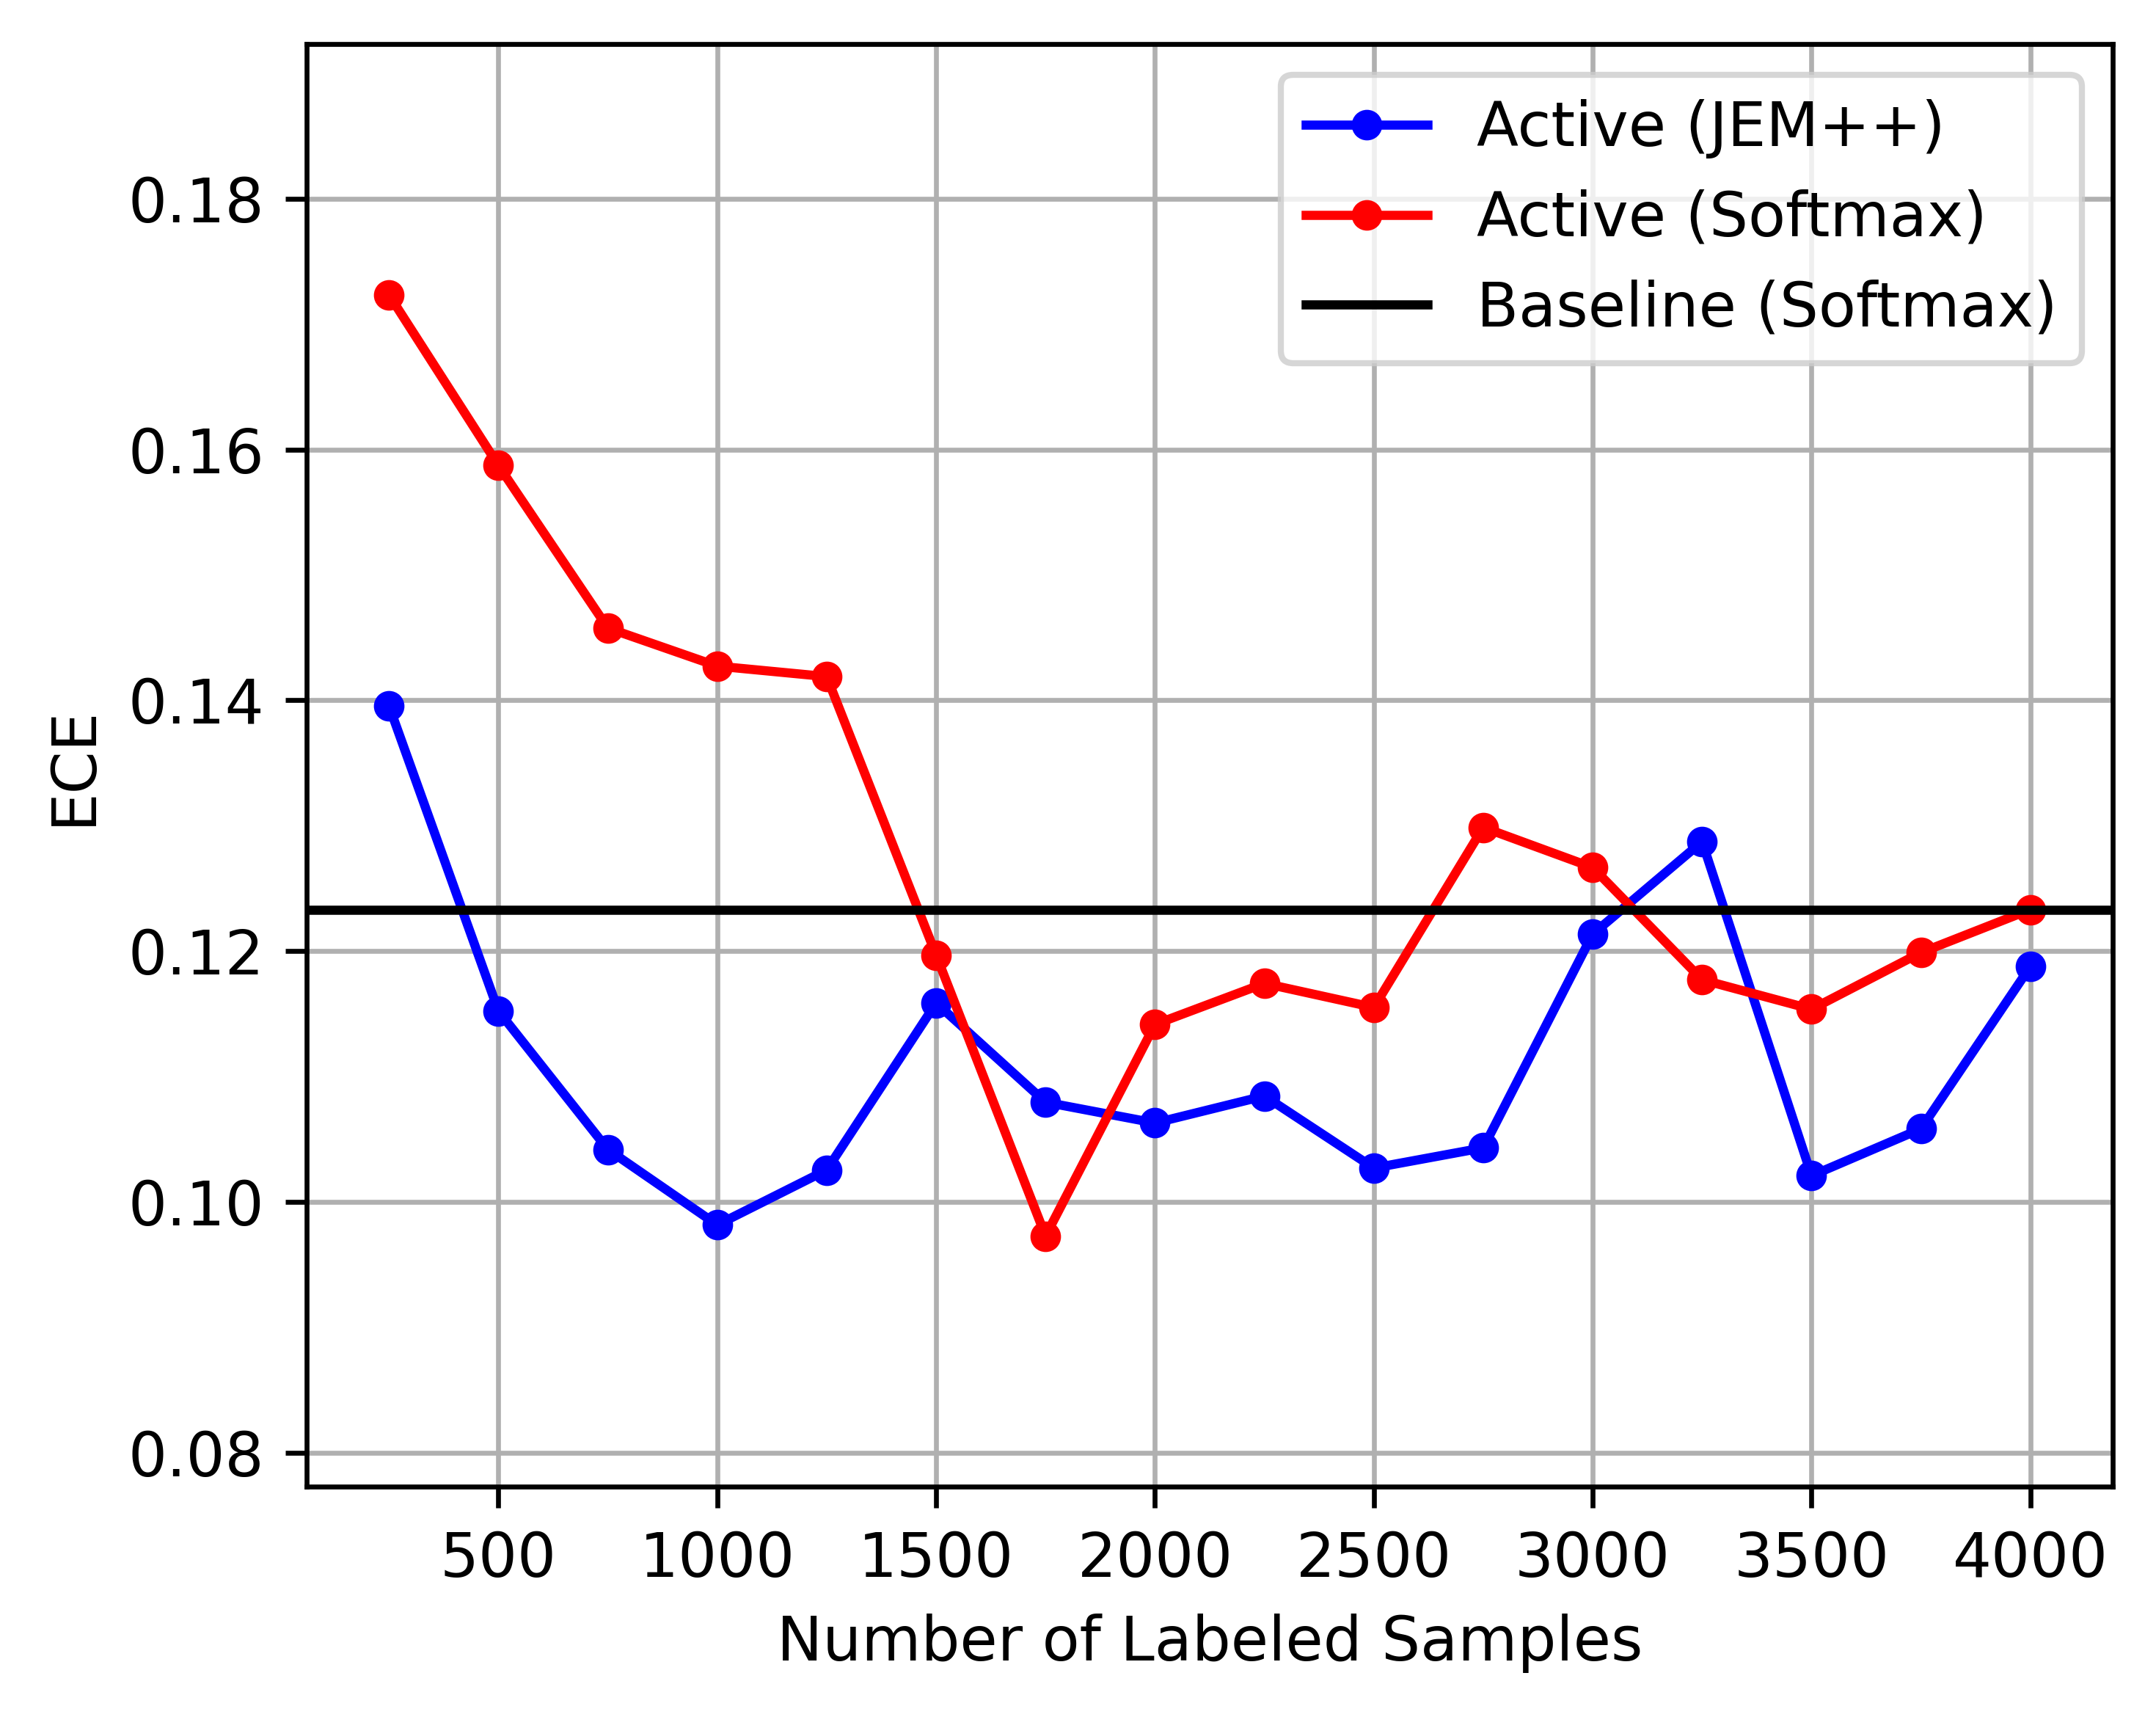

In [17]:
# Define the datasets and optimization methods
datasets = df_agg.index.get_level_values("dataset").unique()
optims = df_agg.index.get_level_values("optim").unique()

# Iterate over the datasets
for i, dataset in enumerate(datasets):
    # Iterate over the optimization methods
    for j, optim in enumerate(optims):
        # Filter the data for the current dataset and optimization method
        df_filtered = df_agg.xs((dataset, optim), level=("dataset", "optim"))

        # check if df_filtered is empty, if so skip
        if df_filtered.empty:
            continue

        # check if df_filtered as active_jempp
        if "active_jempp" in df_filtered.index.get_level_values("experiment_type"):
            # Plot the ECE mean for the active calibrated and uncalibrated methods
            df_experiment_active_jempp = df_filtered.xs("active_jempp", level="experiment_type")

            # Create a new figure for each plot
            fig, ax = plt.subplots(figsize=(5, 4), dpi=600)

            ax.plot(
                df_experiment_active_jempp.index,
                df_experiment_active_jempp[("test_ece", "mean")],
                color="b",
                marker="o",
                markersize=4,
                label="Active (JEM++)",
            )

        if "active_softmax" in df_filtered.index.get_level_values("experiment_type"):
            df_active_softmax = df_filtered.xs("active_softmax", level="experiment_type")
            ax.plot(
                df_active_softmax.index,
                df_active_softmax[("test_ece", "mean")],
                color="r",
                marker="o",
                markersize=4,
                label="Active (Softmax)",
            )

        if "baseline_softmax" in df_filtered.index.get_level_values("experiment_type"):
            df_baseline = df_filtered.xs("baseline_softmax", level="experiment_type")
            ax.axhline(
                df_baseline[("test_ece", "mean")].values[0],
                color="black",
                label="Baseline (Softmax)",
            )

        # set min and max y limits (0.2 above and below the min and max values), if min goes below 0, set to 0
        min_y = df_filtered[("test_ece", "mean")].min() - 0.02
        if min_y < 0:
            min_y = 0
        max_y = df_filtered[("test_ece", "mean")].max() + 0.02
        ax.set_ylim([min_y, max_y])

        # Set the title, labels, and legend
        print(dataset, optim)
        ax.set_xlabel("Number of Labeled Samples")
        ax.set_ylabel("ECE")
        ax.legend(loc="best")

        plt.grid()
        plt.tight_layout()
        plt.show()

KeyError: 'basophil'

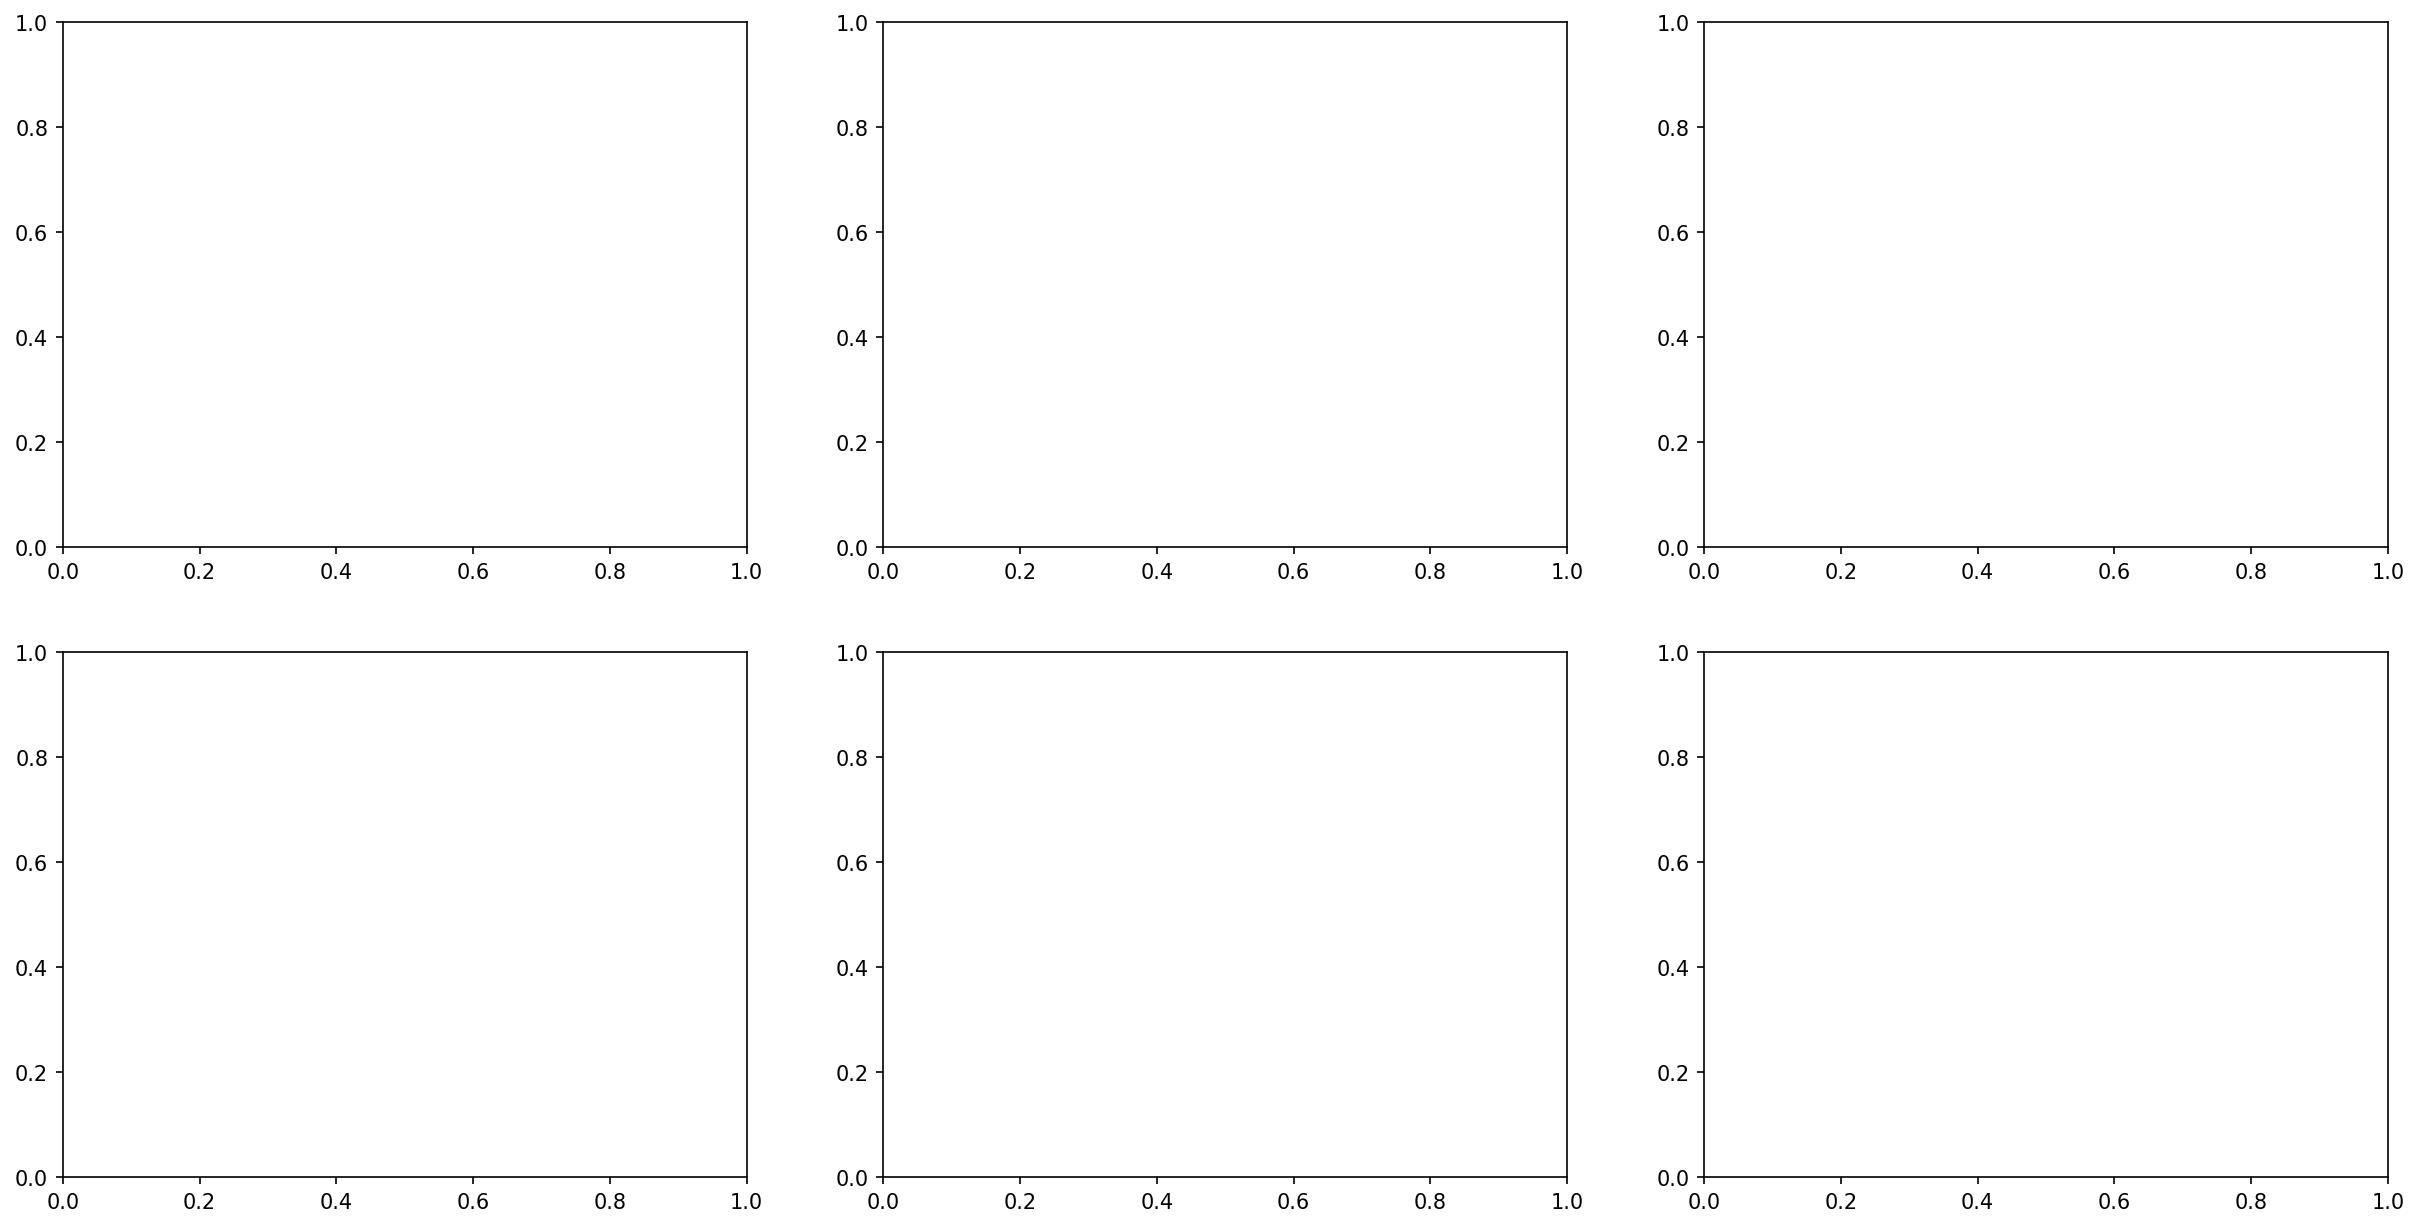

In [ ]:
classes = df["acc_per_class"].values[0].keys()


# Define a function to truncate class names
def truncate_class_name(class_name, max_length=10):
    if len(class_name) > max_length:
        return class_name[:max_length] + "..."
    else:
        return class_name


# Filter for 'active_calibrated' experiment type
df_filtered = df[df["experiment_type"] == "active_jempp"]

# Get unique 'num_labeled' values and select the first, second, and last
num_labeled_values = df_filtered["num_labeled"].unique()
selected_num_labeled = [num_labeled_values[0], num_labeled_values[1], num_labeled_values[-1]]

# Filter for selected 'num_labeled' values
df_filtered = df_filtered[df_filtered["num_labeled"].isin(selected_num_labeled)]

# Group by 'num_labeled'
grouped = df_filtered.groupby("num_labeled")

fig, axs = plt.subplots(2, 3, figsize=(20, 10), dpi=150)

# Iterate over number of labeled samples
for i, (num_labeled, group) in enumerate(grouped):
    # Get the class distribution for each class
    dist_values = np.array([group["class_dist"].apply(lambda x: x[class_name]).values[0] for class_name in classes])

    full_dist_values = np.array([group["full_dist"].apply(lambda x: x[class_name]).values[0] for class_name in classes])

    classnames = [truncate_class_name(class_name) for class_name in classes]

    axs[0, i].bar(classes, full_dist_values, color="gray", zorder=1)
    axs[0, i].bar(classes, dist_values, label=f"active_calibrated {num_labeled}", color="b", zorder=2)
    axs[0, i].set_title(f"{num_labeled} labeled samples")
    axs[0, i].tick_params(axis="y", labelsize=12)
    axs[0, i].set_xticks(np.arange(len(classes)))
    axs[0, i].set_xticklabels(classnames, rotation=45, fontsize=12, rotation_mode="anchor", ha="right")
    axs[0, i].sharey(axs[0, 2])

# Iterate over number of labeled samples
for i, (num_labeled, group) in enumerate(grouped):
    # Get the class distribution for each class
    dist_values = np.array([group["acc_per_class"].apply(lambda x: x[class_name]).values[0] for class_name in classes])

    classnames = [truncate_class_name(class_name) for class_name in classes]

    # Plotting a single group of bars for each experiment type
    axs[1, i].bar(classes, dist_values, label=f"active_calibrated {num_labeled}", color="b")
    axs[1, i].set_title(f"{num_labeled} labeled samples")
    axs[1, i].tick_params(axis="y", labelsize=12)
    axs[1, i].set_xticks(np.arange(len(classes)))
    axs[1, i].set_xticklabels(classnames, rotation=45, fontsize=12, rotation_mode="anchor", ha="right")
    axs[1, i].sharey(axs[1, 2])


plt.tight_layout()
plt.show()
# plt.savefig(f"{dataset}_class_dist.png")